In [4]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import geopandas as gpd
from shapely.geometry import Point, mapping
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")
pd.options.display.float_format = '{:20.2f}'.format
pd.options.mode.chained_assignment = None

import cityImage as ci

In [5]:
city_name = 'Muenster'
epsg = 25832
crs = 'EPSG:'+str(epsg)

### Download from OSM the drive network

Choose between the following methods:
* `OSMplace`, provide an OSM place name (e.g. City).
* `polygon`, provide an WGS polygon of the case-study area.
* `distance_from_address`, provide a precise address and define parameter `distance` (which is otherwise not necessary)

In [7]:
place = 'Muenster, Germany'
download_method = 'OSMplace'
distance = None

nodes_graph, edges_graph = ci.get_network_fromOSM(place, download_method, 'drive', epsg, distance = distance)
nodes_graph, edges_graph = ci.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_islands = True,
                            self_loops = True, same_vertexes_edges = True)

# Creating and saving the dual geodataframes
nodesDual_graph, edgesDual_graph = ci.dual_gdf(nodes_graph, edges_graph, epsg)

### Alternatively, Load from local path (when already processed the network)

In [9]:
input_path = 'Outputs/'+city_name+'/entireNetwork/'

nodes_graph = gpd.read_file(input_path+city_name+'_nodes.shp')
edges_graph = gpd.read_file(input_path+city_name+'_edges.shp')
nodesDual_graph = gpd.read_file(input_path+city_name+'_nodesDual.shp')
edgesDual_graph = gpd.read_file(input_path+city_name+'_edgesDual.shp')

try:
    nodes_graph, edges_graph = nodes_graph.to_crs(epsg=epsg), edges_graph.to_crs(epsg=epsg)
    nodesDual_graph, edgesDual_graph = nodesDual_graph.to_crs(epsg=epsg), edgesDual_graph.to_crs(epsg=epsg)
except:
    nodes_graph.crs, edges_graph.crs = crs, crs
    nodesDual_graph.crs, edgesDual_graph.crs = crs, crs
    
nodes_graph.index, edges_graph.index, nodesDual_graph.index = nodes_graph.nodeID, edges_graph.edgeID, nodesDual_graph.edgeID
nodes_graph.index.name, edges_graph.index.name, nodesDual_graph.index.name = None, None, None

### Visualise 

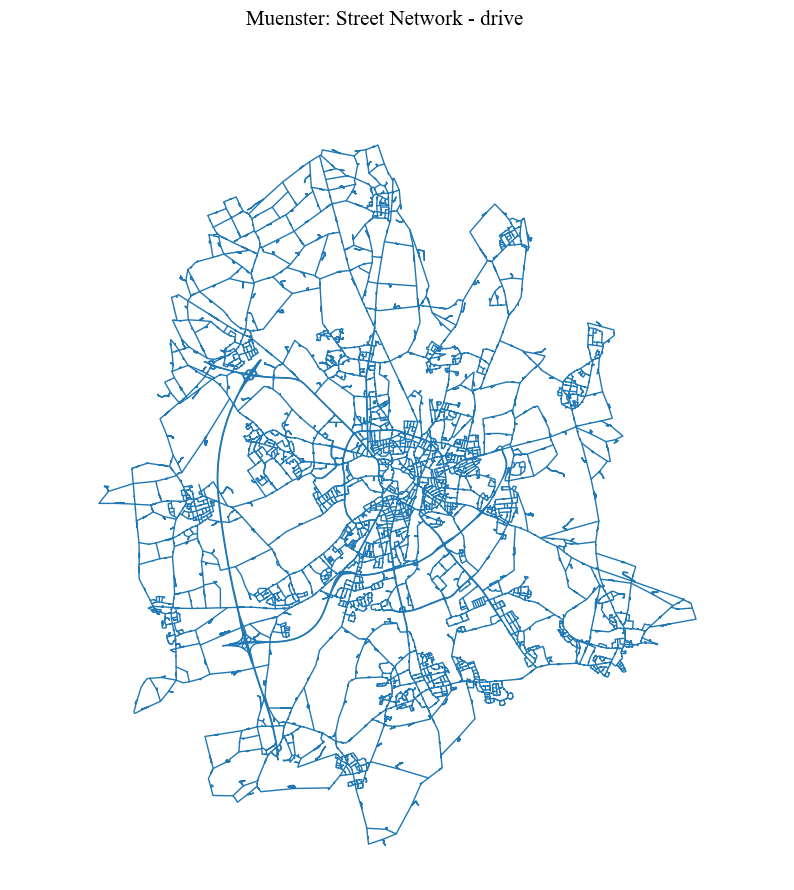

In [10]:
fig = ci.plot_gdf(edges_graph, black_background = False, figsize = (10,10), title = city_name+': Street Network - drive')

## District identification

In [11]:
# creating dual_graph
dual_graph = ci.dual_graph_fromGDF(nodesDual_graph, edgesDual_graph)

Different weights can be used to extract the partitions. `None` indicates that no weights will be used 
(only topological relationships will matter). The function returns a GeoDataFrame with partitions assigned to edges,
with column named as `p_name_weight` (e.g. `p_length`).

In [19]:
weights = ['length', 'rad', None]
districts = edges_graph.copy()
for weight in weights:
    districts = ci.identify_regions(dual_graph, districts, weight = weight)

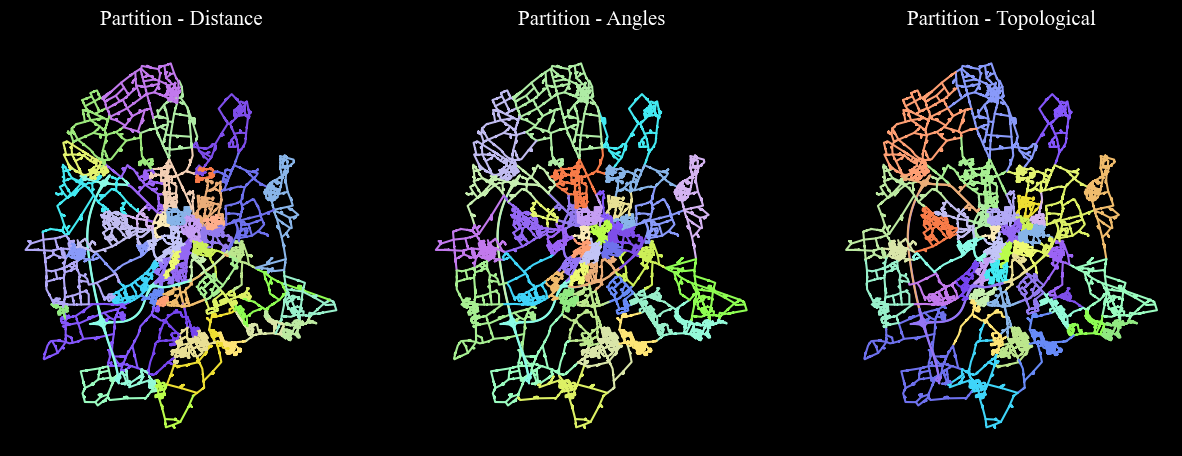

In [25]:
# visualising
columns = ['p_length','p_rad', 'p_topo']
titles = ['Partition - Distance', 'Partition - Angles', 'Partition - Topological']

nlabels = max([len(districts[column].unique()) for column in columns])
cmap = ci.rand_cmap(nlabels = nlabels, type_color='bright')
fig = ci.plot_grid_gdf_columns(districts, columns = columns, titles = titles, geometry_size = 1.5, cmap = cmap, black_background = True, 
                  legend = False, figsize = (15, 10), ncols = 3, nrows = 1)

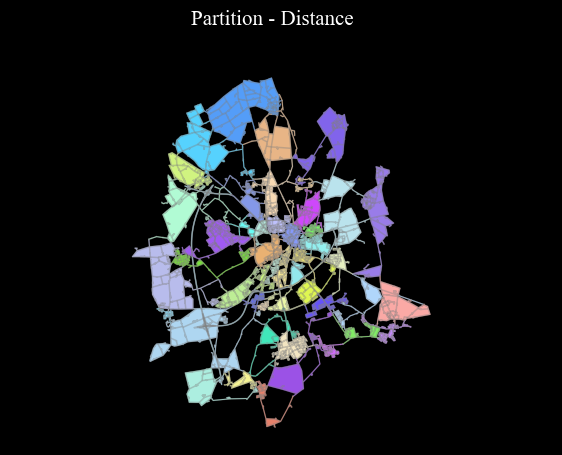

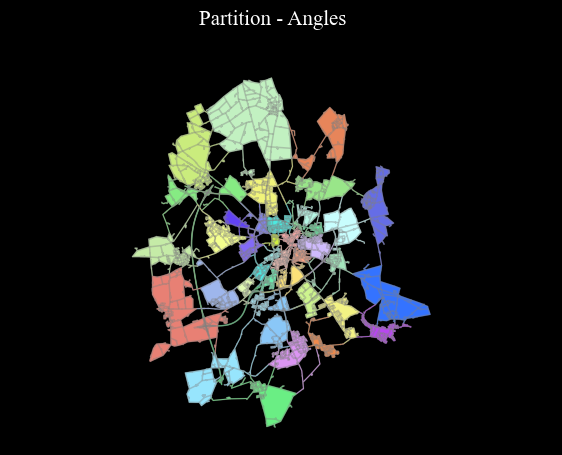

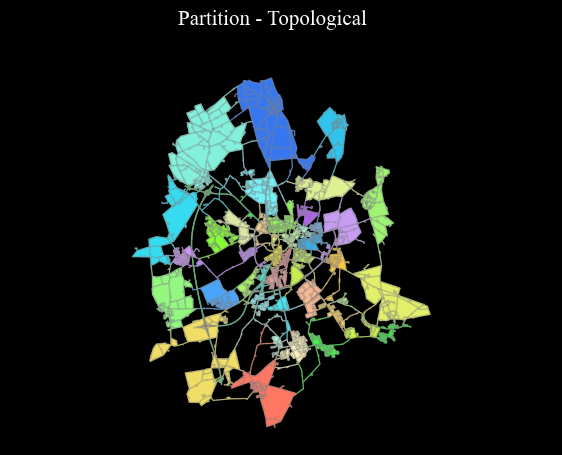

In [28]:
for n, column in enumerate(columns):
    cmap = ci.rand_cmap(nlabels = len(districts[column].unique()), type_color='bright')
    partitions = ci.polygonise_partitions(districts, column, convex_hull = False)
    ci.plot_gdf(partitions, column = column, cmap = cmap, title =  titles[n], black_background = True,  figsize = (7, 5), 
               base_map_gdf = districts, base_map_color = 'grey', base_map_zorder = 1)

In [29]:
# saving
saving_path = 'Outputs/'+city_name+'/entireNetwork/'
districts.to_file(saving_path+city_name+"_edges.shp", driver='ESRI Shapefile')

## Assigning regions to the Pedestrian Street Network
### Case-study area (pedestrian walkable network). It should be ottained via notebook 01-Nodes_Paths
This set of functions assigns regions to a walkable network for further modelling in Pedestrian Simulation, for example.
The simply identifiaction of regions (districts) region from the urban configuration ends above.

In [30]:
input_path = 'Outputs/'+city_name+'/'
nodes_graph_ped = gpd.read_file(input_path+city_name+'_nodes.shp')
edges_graph_ped = gpd.read_file(input_path+city_name+'_edges.shp')

try:
    nodes_graph_ped, edges_graph_ped = nodes_graph_ped.to_crs(epsg=epsg), edges_graph_ped.to_crs(epsg=epsg)
except:
    nodes_graph_ped.crs, edges_graph_ped.crs = crs, crs

nodes_graph_ped.index, edges_graph_ped.index  = nodes_graph_ped.nodeID, edges_graph_ped.edgeID
nodes_graph_ped.index.name, edges_graph_ped.index.name  = None, None

### Otherwise, get it from OSM:

Choose between the following methods:
* `OSMplace`, provide an OSM place name (e.g. City).
* `polygon`, provide an WGS polygon of the case-study area.
* `distance_from_address`, provide a precise address and define parameter `distance` (which is otherwise not necessary)

In [32]:
place = 'Domplatz, Muenster, Germany' ## must be different from the area used for the drive network
download_method = 'distance_from_address'
distance = 2500

nodes_graph_ped, edges_graph_ped = ci.get_network_fromOSM(place, download_method, 'walk', epsg, distance = distance)
nodes_graph_ped, edges_graph_ped = ci.clean_network(nodes_graph_ped, edges_graph_ped, dead_ends = True, 
                                remove_islands = True, self_loops = True, same_vertexes_edges = True)

### Option 2 - Load it from local path

### Visualising

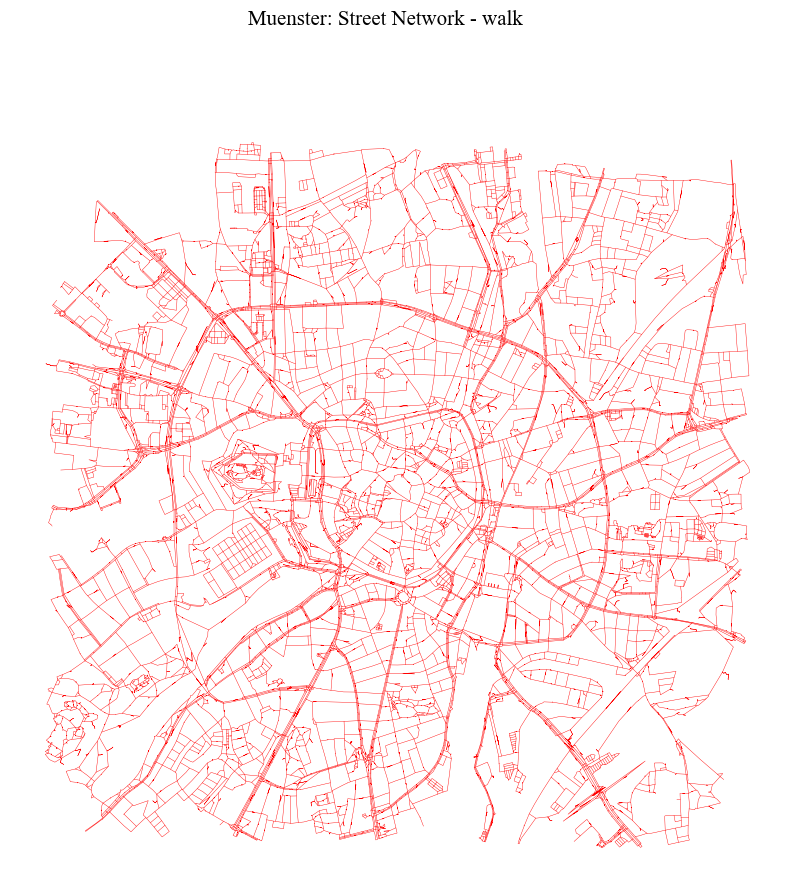

In [41]:
fig = ci.plot_gdf(edges_graph_ped, black_background = False, figsize = (10,10), title = city_name+': Street Network - walk',  
                  color = 'red', geometry_size = 0.3)

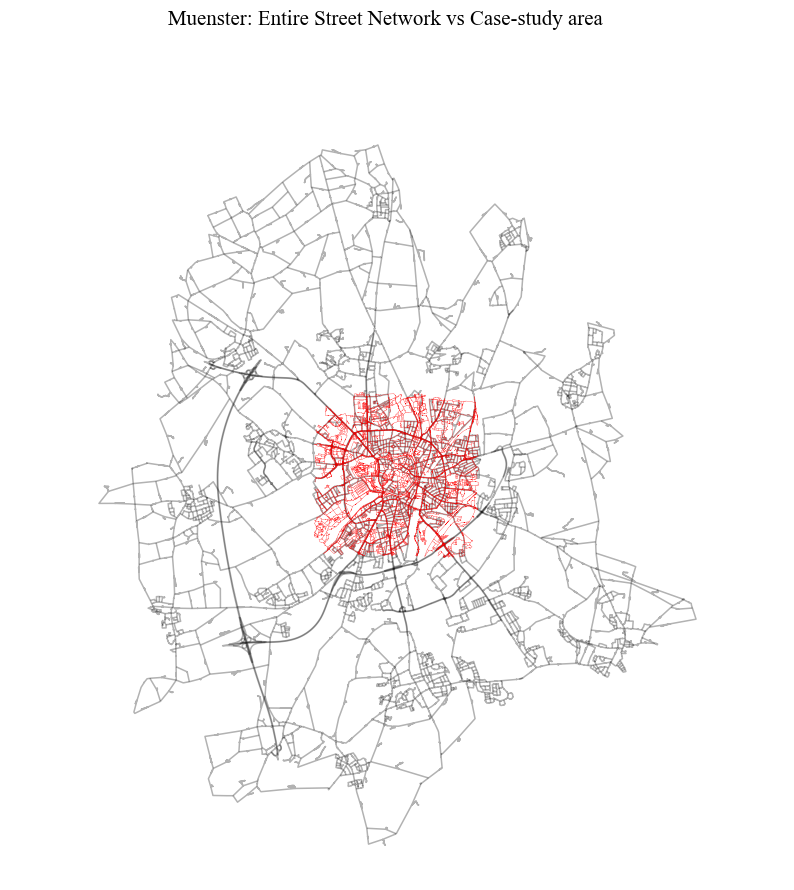

In [40]:
fig = ci.plot_gdf(edges_graph_ped, scheme = None,  black_background = False, figsize = (10,10), title = 
              city_name+': Entire Street Network vs Case-study area', color = 'red', geometry_size = 0.2,
             base_map_gdf = edges_graph, base_map_color = 'black', base_map_alpha = 0.3)

## Assigning nodes and edges in the pedestrian network to Partitions

In [42]:
# choosing the type of partition to be used
column = 'p_length'
min_size_district = 10

In [43]:
dc = dict(districts[column].value_counts())

## ignore small portions
to_ignore = {k: v for k, v in dc.items() if v <= min_size_district} 
tmp = districts[~((districts[column].isin(to_ignore))| (districts[column] == 999999))].copy()

partitions = ci.polygonise_partitions(tmp, column)
nodes_graph_ped = ci.district_to_nodes_from_polygons(nodes_graph_ped, partitions, column)
nodes_graph_ped[column] = nodes_graph_ped[column].astype(int)

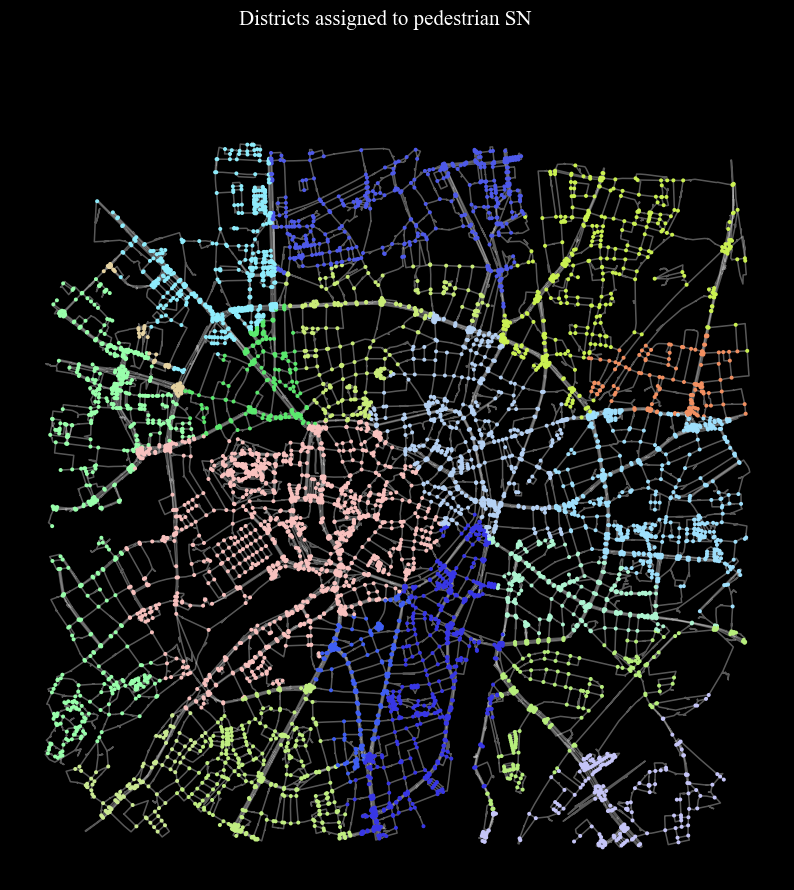

In [44]:
# visualisation
cmap = ci.rand_cmap(nlabels = len(nodes_graph_ped[column].unique()), type_color='bright')
fig = ci.plot_gdf(nodes_graph_ped, column = column, title = 'Districts assigned to pedestrian SN', cmap = cmap, 
                  geometry_size = 3.5, base_map_gdf = edges_graph_ped, base_map_color = 'white', base_map_alpha = 0.35,
                black_background = True, legend = False, figsize = (10,10))

### Fixing disconnected districts and assigning nodes to existing connected districts

In [45]:
nodes_graph_ped = ci.amend_nodes_membership(nodes_graph_ped, edges_graph_ped, column, min_size_district)
   
# assigning gateways
nodes_graph_ped = ci.find_gateways(nodes_graph_ped, edges_graph_ped, column)

## Visualising the final division

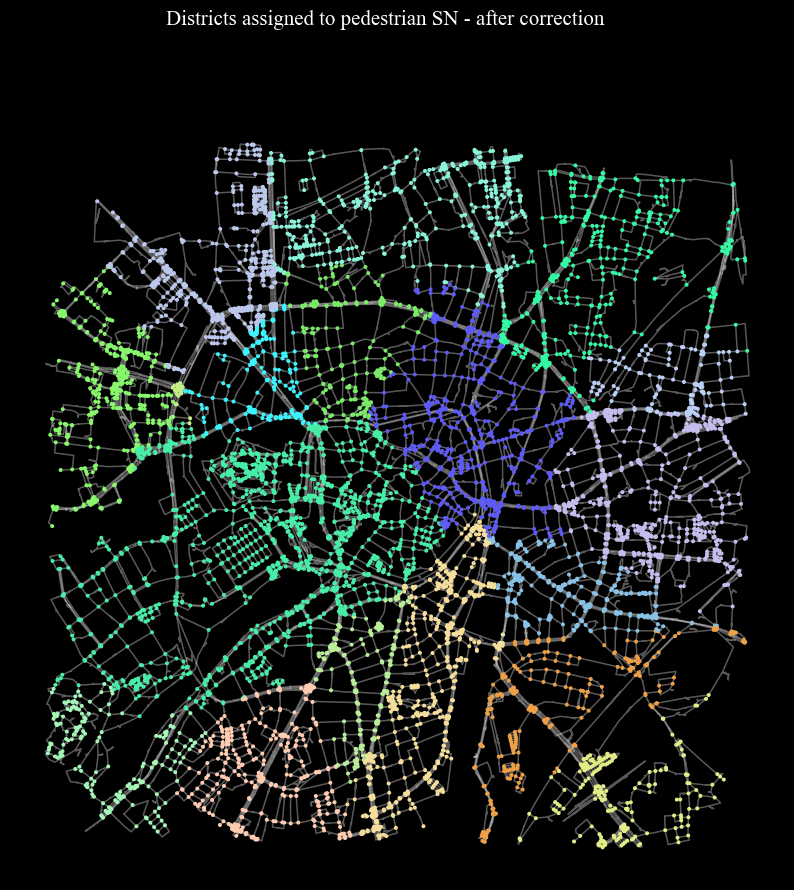

In [46]:
cmap = ci.rand_cmap(nlabels = len(nodes_graph_ped[column].unique()), type_color='bright')
fig = ci.plot_gdf(nodes_graph_ped, column = column, title = 'Districts assigned to pedestrian SN - after correction', 
               cmap = cmap, geometry_size = 3.5, base_map_gdf = edges_graph_ped, base_map_color = 'white', 
                  base_map_alpha = 0.35, black_background = True, legend = False, figsize = (10,10))

In [47]:
nodes_graph_ped['district'] = nodes_graph_ped[column].astype(int)

In [88]:
# saving
saving_path = 'Outputs/'+city_name+'/'
nodes_graph_ped.to_file(saving_path+city_name+"_nodes.shp", driver='ESRI Shapefile')
edges_graph_ped.to_file(saving_path+city_name+"_edges.shp", driver='ESRI Shapefile')